In [1]:
import numpy as np
from scipy.linalg import expm, logm

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from matplotlib import rcParams
plt.style.use('seaborn-white')
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Georgia'

In [4]:
def random_symmetric_matrix(size):
    mat = np.zeros((size, size))
    for row in range(size):
        for col in range(row + 1):
            current = np.random.normal(0, 1, 1)
            mat[row, col] = current
            mat[col, row] = current
    return mat

In [5]:
a = random_symmetric_matrix(4)
print(a)

[[-1.05841927 -0.30185276  0.79650744  0.84194254]
 [-0.30185276  0.17741766  0.01299779 -0.05098269]
 [ 0.79650744  0.01299779 -0.56333683 -0.34640057]
 [ 0.84194254 -0.05098269 -0.34640057  0.76792692]]


In [6]:
print(expm(a))

[[ 0.75582413 -0.27463832  0.3403559   0.89633543]
 [-0.27463832  1.24164719 -0.05483981 -0.22608972]
 [ 0.3403559  -0.05483981  0.74642683 -0.18365279]
 [ 0.89633543 -0.22608972 -0.18365279  2.66944184]]


In [7]:
upper = np.triu(a)
upper = upper[np.nonzero(upper)].flatten()
print(upper.shape)

(10,)


4 x 4 covariance matrices have 10 elements in the upper triangle. Want to reduce to just 2 latent dimensions. Generate smooth temporal dynamics in the latent space. Use linear mapping to 10 dimensional Euclidean space and add Gaussian noise. Create symmetric matrix and exponentiate. 

In [8]:
def polynomial_dynamics(t, coefs):
    out = 0
    for i in range(coefs.shape[0]):
        out += t ** i * coefs[i]
    return out

In [9]:
latent_dynamics = np.zeros((20, 2))
latent_dynamics[:, 0] = polynomial_dynamics(np.linspace(-2, 2, 20), np.asarray([-1, 1, 0.5, -0.1]))
latent_dynamics[:, 1] = polynomial_dynamics(np.linspace(-2, 2, 20), np.asarray([-0.5, -1, 0.2, 0.5]))

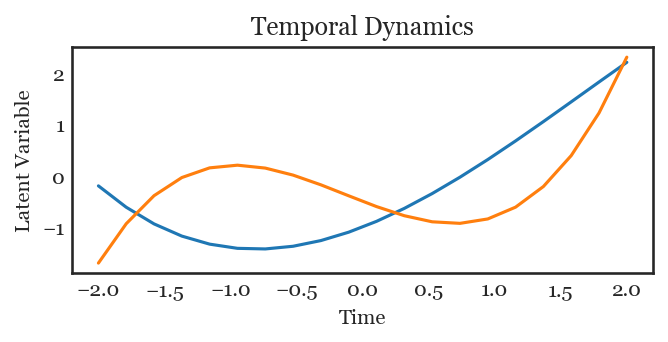

In [10]:
fig = plt.figure(figsize=(5, 2), dpi=150)
plt.plot(np.linspace(-2, 2, 20), latent_dynamics[:, 0])
plt.plot(np.linspace(-2, 2, 20), latent_dynamics[:, 1])
plt.xlabel('Time')
plt.ylabel('Latent Variable')
plt.title('Temporal Dynamics')
plt.show()

In [11]:
print(latent_dynamics.shape)

(20, 2)


Latent dynamics are described by [time, latent dim] matrix and we want to map to [time, upper dim] so we need [latent dim, upper dim] matrix transformation.

In [12]:
mapping = np.random.uniform(-1, 1, 20).reshape((2, 10))

In [13]:
print(mapping)

[[ 0.82346306 -0.78142123 -0.9138665   0.16970096 -0.90543298  0.64141364
  -0.0627992   0.04023985 -0.49209049  0.39629583]
 [-0.0734502   0.79151051 -0.75369589  0.37254328  0.57672669 -0.05477195
   0.68615251 -0.81027364 -0.32727589  0.54829081]]


In [14]:
upper_dynamics = np.dot(latent_dynamics, mapping)

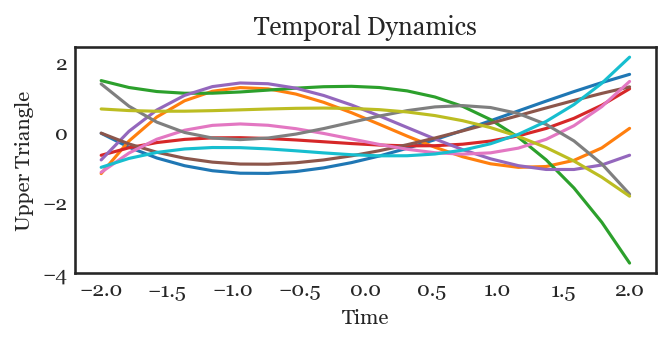

In [15]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(10):
    plt.plot(np.linspace(-2, 2, 20), upper_dynamics[:, i])
plt.xlabel('Time')
plt.ylabel('Upper Triangle')
plt.title('Temporal Dynamics')
plt.show()

In [16]:
print(upper_dynamics.shape)

(20, 10)


In [17]:
noisy_dynamics = upper_dynamics + np.random.normal(0, 0.5, 200).reshape((20, 10))

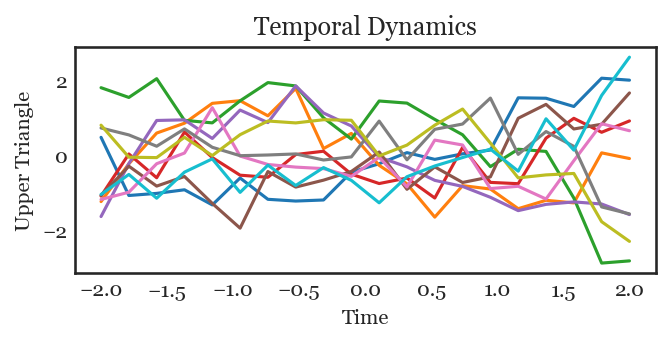

In [18]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(10):
    plt.plot(np.linspace(-2, 2, 20), noisy_dynamics[:, i])
plt.xlabel('Time')
plt.ylabel('Upper Triangle')
plt.title('Temporal Dynamics')
plt.show()

In [19]:
def create_symmetric_matrix(upper):
    mat = np.zeros((4, 4))
    mat[0, :] = upper[:4]
    mat[1, 1:] = upper[4:7]
    mat[2, 2:] = upper[7:9]
    mat[3, 3] = upper[9]
    for i in range(1, 4):
        for j in range(i):
            mat[i, j] = mat[j, i]
    return mat

In [20]:
observed_matrix = create_symmetric_matrix(noisy_dynamics[19, :])
print(observed_matrix)

[[ 1.98636384 -0.10418885 -2.83488711  0.89858049]
 [-0.10418885 -1.59942505  1.64549778  0.63726414]
 [-2.83488711  1.64549778 -1.58121565 -2.31450743]
 [ 0.89858049  0.63726414 -2.31450743  2.59989475]]


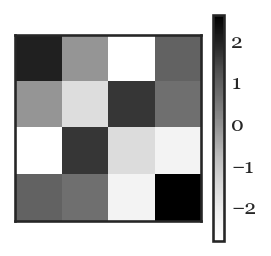

In [21]:
plt.figure(figsize=(2, 2), dpi=150)
plt.imshow(observed_matrix)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

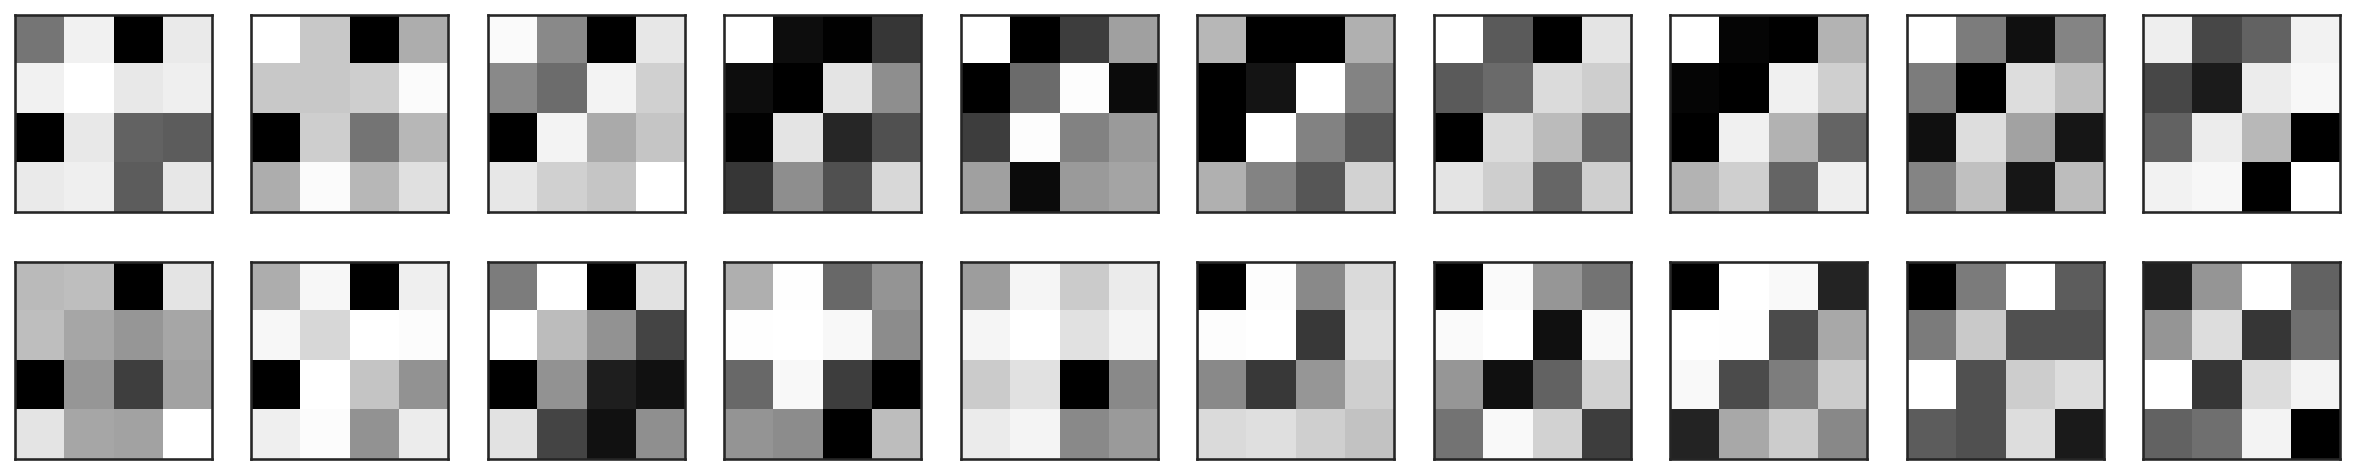

In [22]:
fig = plt.figure(figsize=(20, 4), dpi=150)
for i in range(20):
    plt.subplot(2, 10, i + 1)
    observed_matrix = create_symmetric_matrix(noisy_dynamics[i, :])
    plt.imshow(observed_matrix)
    plt.xticks([])
    plt.yticks([])
plt.show()

**3 x 3 matrices for sanity model checking is almost the simplest scenario.**

In [23]:
def create_symmetric_matrix(upper):
    mat = np.zeros((3, 3))
    mat[0, :] = upper[:3]
    mat[1, 1:] = upper[3:5]
    mat[2, 2] = upper[5]
    for i in range(1, 3):
        for j in range(i):
            mat[i, j] = mat[j, i]
    return mat

In [24]:
nt = 500
X = np.linspace(-2, 2, nt)

In [25]:
latent_dynamics = np.zeros((nt, 6))
latent_dynamics[:, 0] = polynomial_dynamics(X, np.asarray([-1, 1, 0.5, -0.1]))
latent_dynamics[:, 1] = polynomial_dynamics(X, np.asarray([-0.5, -1, 0.2, 0.5]))
latent_dynamics[:, 2] = polynomial_dynamics(X, np.asarray([0.5, 0.1, -0.2, 0.2]))
latent_dynamics[:, 3] = polynomial_dynamics(X, np.asarray([0.1, 0.5, -0.2, 0.2]))
latent_dynamics[:, 4] = polynomial_dynamics(X, np.asarray([0, 0.5, -0.1, -0.2]))
latent_dynamics[:, 5] = polynomial_dynamics(X, np.asarray([0, 0.1, 0.1, -0.2]))

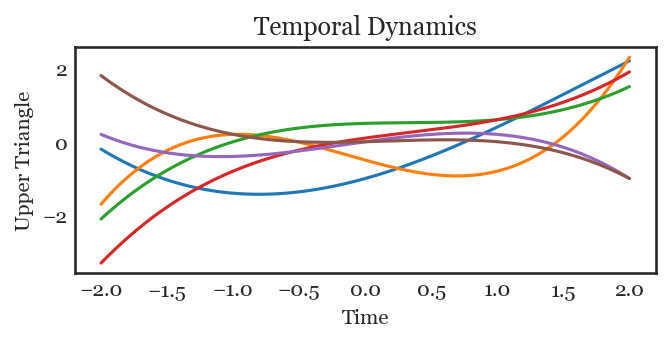

In [26]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(6):
    plt.plot(X, latent_dynamics[:, i])
plt.xlabel('Time')
plt.ylabel('Upper Triangle')
plt.title('Temporal Dynamics')
plt.show()

In [27]:
independent_noise = np.random.normal(0, 0.2, nt * 6).reshape((nt, 6))

In [28]:
noisy_dynamics = latent_dynamics + independent_noise

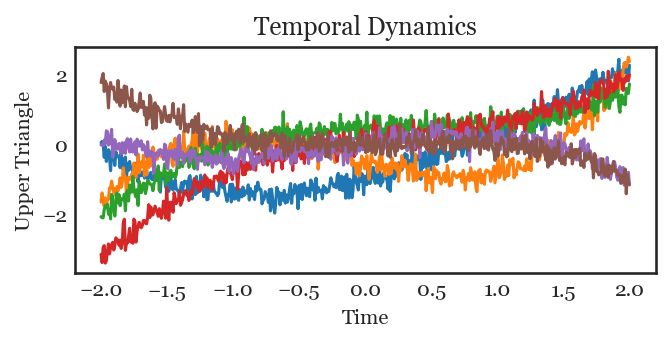

In [29]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(6):
    plt.plot(X, noisy_dynamics[:, i])
plt.xlabel('Time')
plt.ylabel('Upper Triangle')
plt.title('Temporal Dynamics')
plt.show()

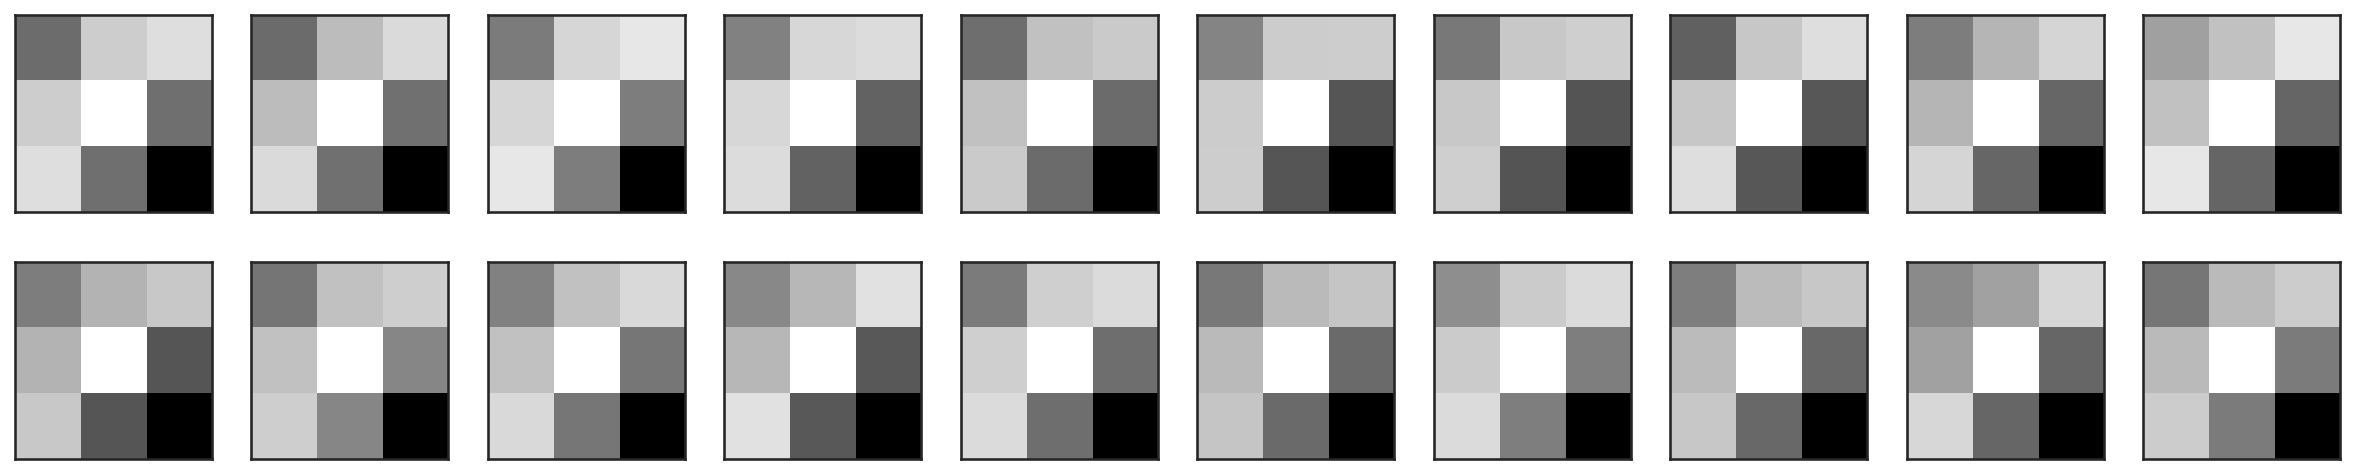

In [30]:
fig = plt.figure(figsize=(20, 4), dpi=150)
for i in range(20):
    plt.subplot(2, 10, i + 1)
    observed_matrix = create_symmetric_matrix(noisy_dynamics[i, :])
    plt.imshow(observed_matrix)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [31]:
mapping = np.random.uniform(-1, 1, 36).reshape((6, 6))
correlated_noise = np.dot(independent_noise, mapping)

In [32]:
noisy_dynamics = latent_dynamics + correlated_noise

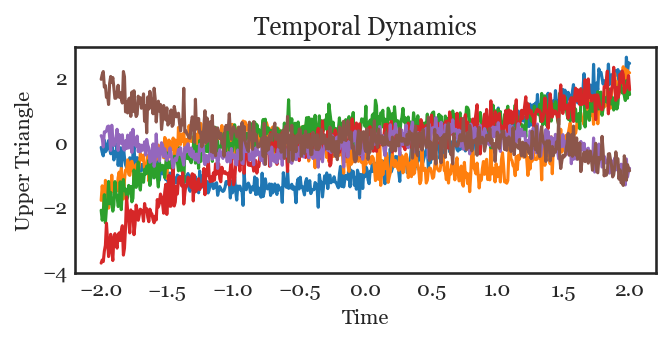

In [33]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(6):
    plt.plot(X, noisy_dynamics[:, i])
plt.xlabel('Time')
plt.ylabel('Upper Triangle')
plt.title('Temporal Dynamics')
plt.show()

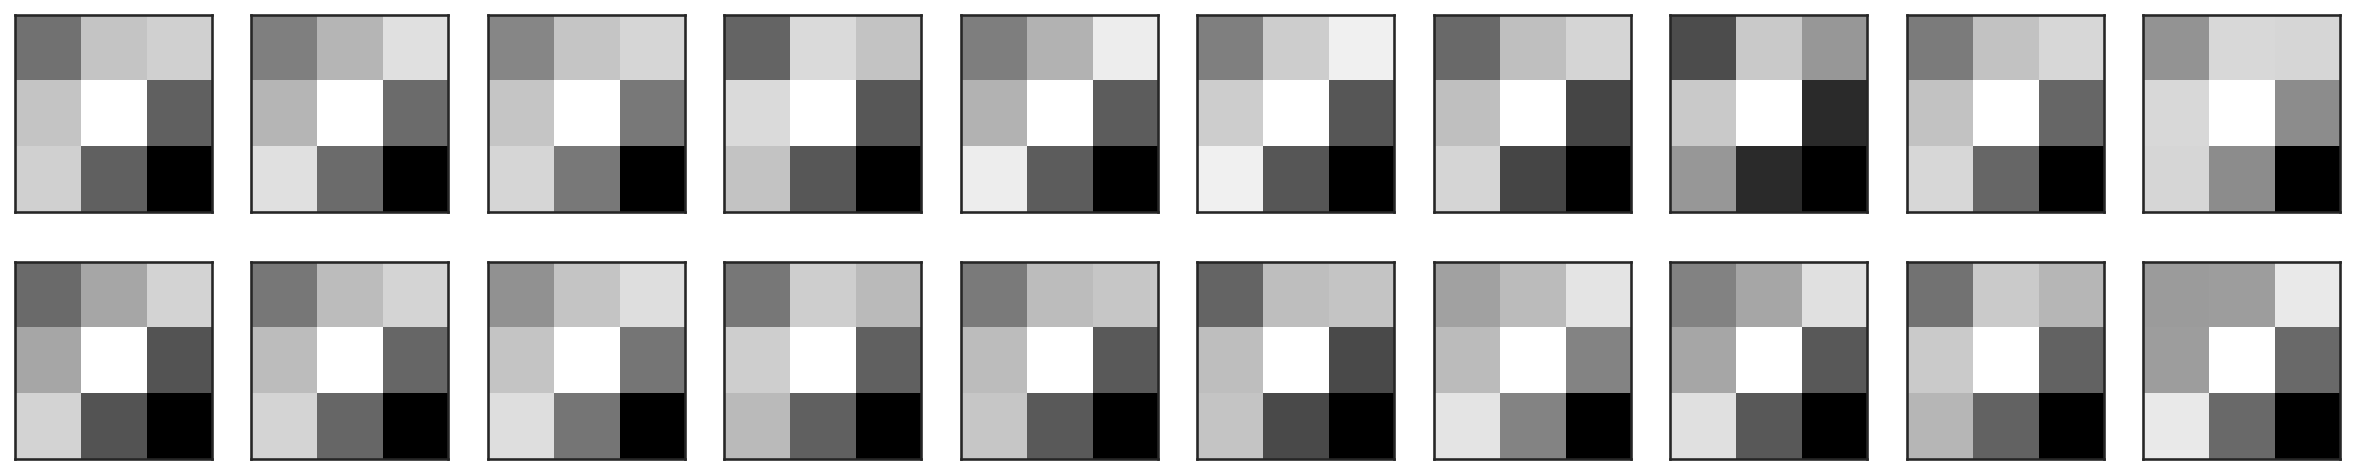

In [34]:
fig = plt.figure(figsize=(20, 4), dpi=150)
for i in range(20):
    plt.subplot(2, 10, i + 1)
    observed_matrix = create_symmetric_matrix(noisy_dynamics[i, :])
    plt.imshow(observed_matrix)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [36]:
kernel = RBF(length_scale=1.0, length_scale_bounds=(0.2, 2.0)) \
+ WhiteKernel(noise_level=0.5, noise_level_bounds=(0.1, 1.0))
model_list = []
X_train = X.reshape((-1, 1))
posterior_mean = np.zeros((nt, 6))
posterior_std = np.zeros((nt, 6))
for i in range(6):
    y_train = noisy_dynamics[:, i]
    model = GaussianProcessRegressor(kernel=kernel).fit(X_train, y_train)
    model_list.append(model)
    current_mean, current_std = model.predict(X_train, return_std=True)
    posterior_mean[:, i] = current_mean
    posterior_std[:, i] = current_std

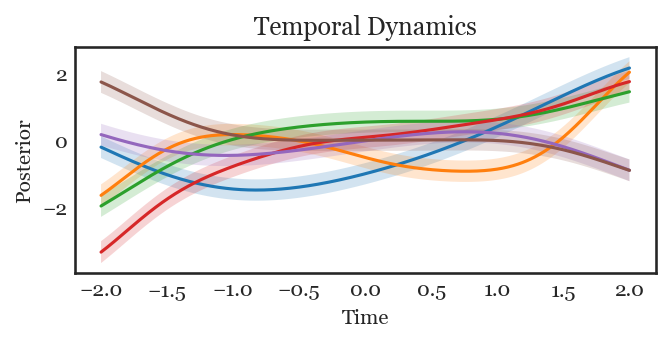

In [37]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=150)
for i in range(6):
    plt.plot(X, posterior_mean[:, i])
    ax.fill_between(X, posterior_mean[:, i] - posterior_std[:, i], posterior_mean[:, i] + posterior_std[:, i], alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Posterior')
plt.title('Temporal Dynamics')
plt.show()

In [38]:
error = posterior_mean - latent_dynamics
print(np.mean(error ** 2))
print(np.mean(posterior_std ** 2))

0.001372578754726413
0.10142593850392898


For Norbert's LFP data, we can divide trials for a rat into groups by different odors or in vs out-of sequence. In the kernel, we would have group indicators and time. Use supervised linear dimensionality reduction and maybe look into theoretical results on probabilistic PCA regression.

**Model fitting pseudo code:**
i. Initiate six different GP models with the same kernel and hyper-parameter values
ii. On a grid, iterate through hyper-parameter values, evaluate likelihoods of all GPs, and calculate the product
iii. Find the best hyper-parameter values and obtain posterior draws
iv. Evaluate MSE on training and hold-out data points to see how much bias there is.

**NeurIPS paper outline:**
i. one page of introduction and another page of background
ii. two pages of Log-Euclidean GP regression including model formulation, theoretical results and simulation studies
iii. two pages of PCA GP regression with a realistic example and rat replay LFP data application
iv. two pages of neural network GP regression to compare different architectures and inference algorithms on real data
v. discussion
vi. proofs and experiment details in appendix

**Priorities:**
i. Implement product GP and perform model sanity check on simple examples 
ii. Fit product GP on rat data after dimensionaltiy reduction (unsupervised PCA)
iii. Implement full Bayesian PCA GP model and sampling algorithm

For the deep learning part, we can start with a single layer neural network with sigmoid activation, then multi-layer and de-convolutional networks. We believe de-convolutional networks are expressive enough as the decoders in VAEs are able to generate realistic images. For future work, an immediate practical need is to have model building, checking, and diagnostic principles. More broadly, how does this fit into the interplay between neural networks and GPs? Can we develop more in-depth theory and better inference algorithms?

*How does the Log-Euclidean transformation introduce correlation in the error distribution?*

In [39]:
activation = np.zeros((100, 3))
activation[:, 0] = np.sin(np.linspace(5, 10, 100))
activation[:, 1] = np.sin(np.linspace(4, 10, 100))
activation[:, 2] = np.sin(np.linspace(0, 8, 100))

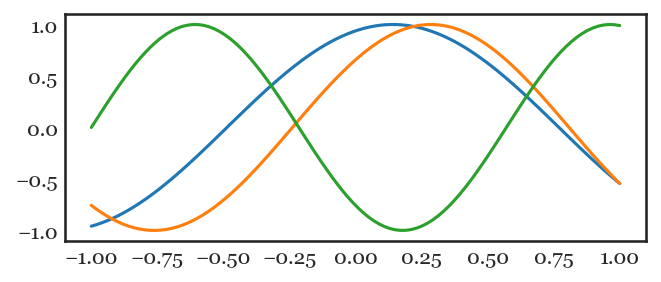

In [40]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(3):
    plt.plot(np.linspace(-1, 1, 100), activation[:, i])
plt.show()

In [41]:
noisy_activation = np.zeros((200, 100, 3))
for i in range(200):
    noisy_activation[i, :, :] = activation + np.random.normal(0, 0.1, 300).reshape((100, 3))

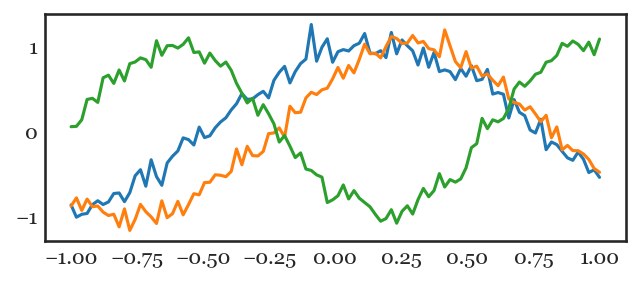

In [42]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(3):
    plt.plot(np.linspace(-1, 1, 100), noisy_activation[0, :, i])
plt.show()

(200, 100, 3)


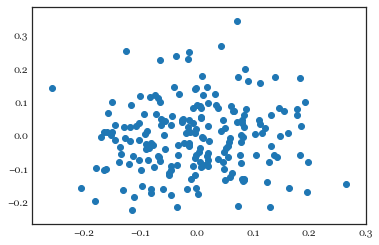

In [43]:
activation_error = noisy_activation - activation
print(activation_error.shape)
plt.scatter(activation_error[:, 0, 0], activation_error[:, 0, 1])
plt.show()

In [44]:
covariance = np.cov(np.mean(noisy_activation, axis=0), rowvar=False)
print(covariance)

[[ 0.38655371  0.39717913 -0.35384634]
 [ 0.39717913  0.50535795 -0.42185263]
 [-0.35384634 -0.42185263  0.4919395 ]]


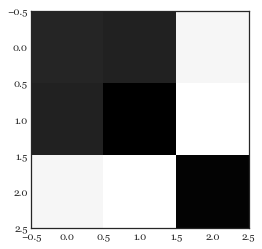

In [45]:
plt.imshow(covariance)
plt.show()

In [46]:
upper = logm(covariance)[np.triu_indices(3)]
print(upper)

[-2.03998877  1.21094388 -0.75266182 -1.76640149 -0.99680124 -1.49101867]


In [47]:
noisy_covariance = np.zeros((200, 3, 3))
for i in range(200):
    noisy_covariance[i, :, :] = np.cov(noisy_activation[i, :, :], rowvar=False)

In [48]:
covariance_error = noisy_covariance - np.mean(noisy_covariance, axis=0)
print(covariance_error.shape)

(200, 3, 3)


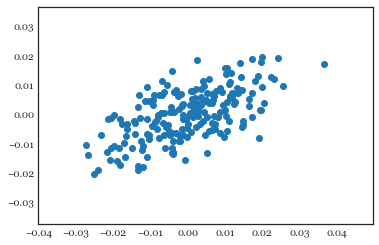

In [49]:
plt.scatter(covariance_error[:, 0, 0], covariance_error[:, 0, 1])
plt.show()

In [50]:
noisy_upper = np.zeros((200, 6))
for i in range(200):
    noisy_upper[i, :] = logm(noisy_covariance[i, :, :])[np.triu_indices(3)]

In [51]:
upper = logm(np.mean(noisy_covariance, axis=0))[np.triu_indices(3)]
print(upper)

[-1.91372399  1.13126518 -0.73032522 -1.65078196 -0.95541461 -1.41989539]


In [52]:
upper_error = noisy_upper - upper
print(upper_error.shape)

(200, 6)


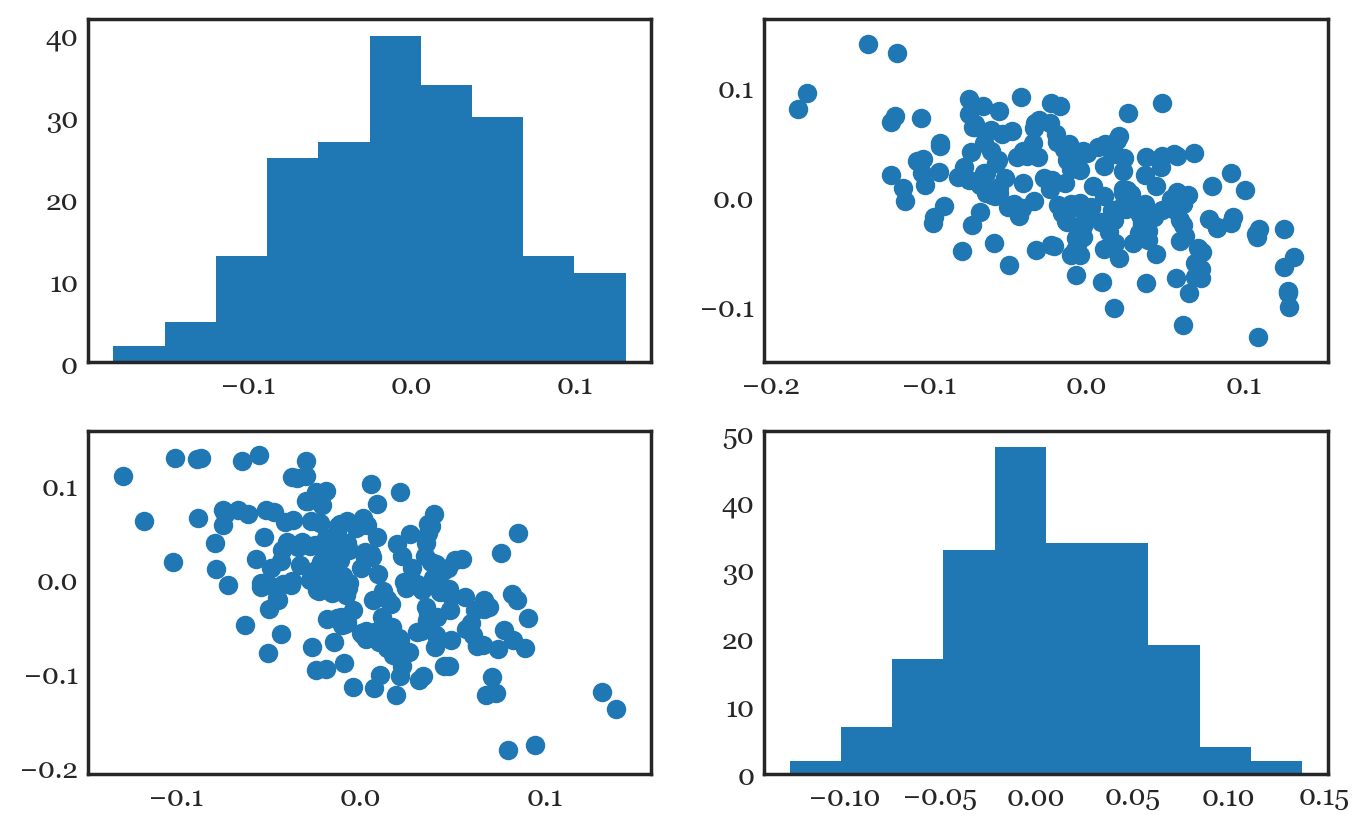

In [68]:
fig = plt.figure(figsize=(8, 5), dpi=200)
plt.subplot(2, 2, 1)
plt.hist(upper_error[:, 0])
plt.subplot(2, 2, 2)
plt.scatter(upper_error[:, 0], upper_error[:, 1])
plt.subplot(2, 2, 3)
plt.scatter(upper_error[:, 1], upper_error[:, 0])
plt.subplot(2, 2, 4)
plt.hist(upper_error[:, 1])
plt.show()

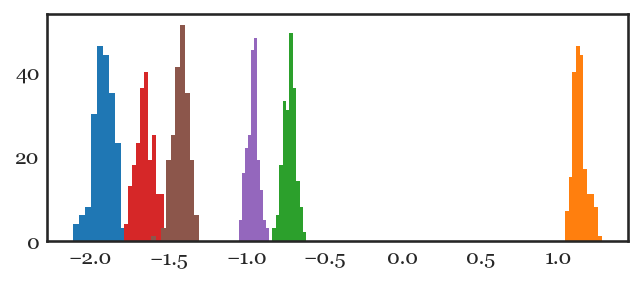

In [59]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(6):
    plt.hist(noisy_upper[:, i])
plt.show()

In [60]:
t_total = 1100
a1 = np.linspace(0, 1, t_total)
b1 = np.linspace(1, 0, t_total)
a2 = np.repeat(0.5, t_total)
b2 = np.repeat(0.5, t_total)
a3 = np.linspace(1, 0, t_total)
b3 = np.linspace(0, 1, t_total)

In [61]:
activation = np.zeros((t_total, 3))
activation[:, 0] = np.sin(np.linspace(0, 20, t_total)) * a1 + np.sin(np.linspace(1, 10, t_total)) * b1 * 0.5
activation[:, 1] = np.sin(np.linspace(0, 20, t_total)) * a2 + np.sin(np.linspace(1, 10, t_total)) * b2 * 0.5
activation[:, 2] = np.sin(np.linspace(0, 20, t_total)) * a3 + np.sin(np.linspace(1, 10, t_total)) * b3 * 0.5

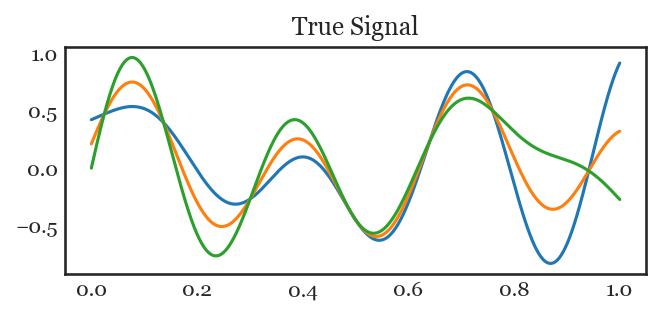

In [93]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(3):
    plt.plot(np.linspace(0, 1, t_total), activation[:, i])
plt.title('True Signal')
plt.show()

In [64]:
noisy_activation = np.zeros((200, t_total, 3))
for i in range(200):
    noisy_activation[i, :, :] = activation + np.random.normal(0, 0.1, t_total * 3).reshape((t_total, 3))

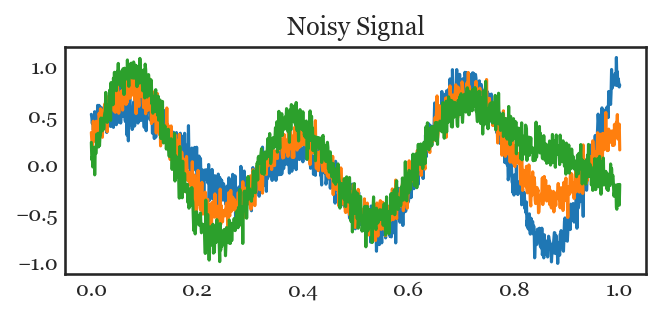

In [94]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(3):
    plt.plot(np.linspace(0, 1, t_total), noisy_activation[0, :, i])
plt.title('Noisy Signal')
plt.show()

In [73]:
noisy_covariance = np.zeros((200, 100, 3, 3))
for i in range(200):
    for j in range(100):
        noisy_covariance[i, j, :, :] = np.cov(noisy_activation[i, (j * 10):(j * 10 + 100), :], rowvar=False)

In [74]:
mean_covariance = np.zeros((100, 3, 3))
mean_covariance = np.mean(noisy_covariance, axis=0)

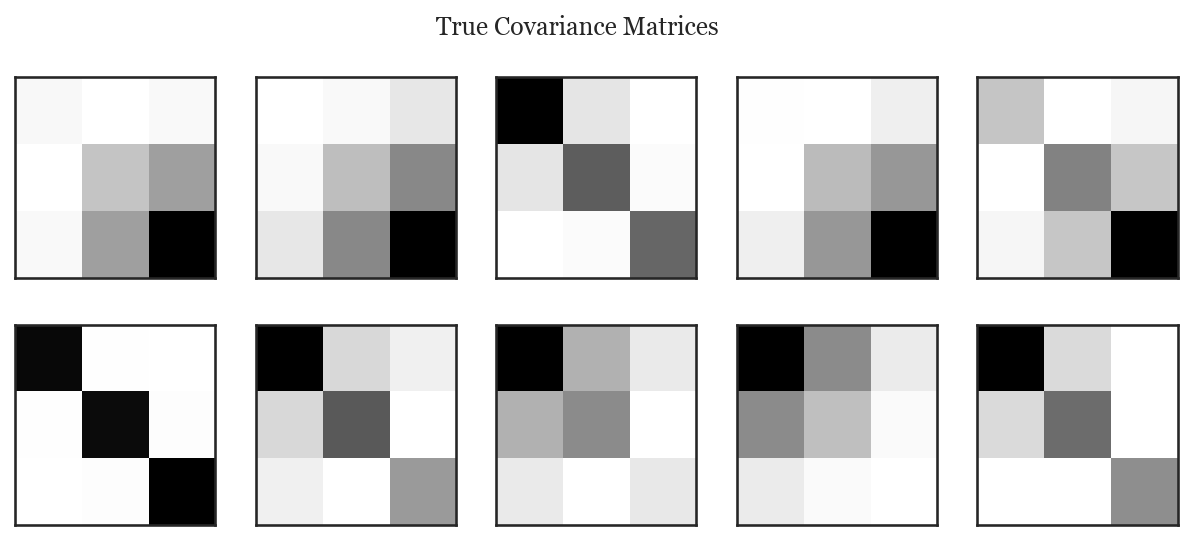

In [100]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for j in range(10):
    plt.subplot(2, 5, j + 1)
    plt.imshow(mean_covariance[j * 10, :, :])
    plt.xticks([])
    plt.yticks([])
plt.suptitle('True Covariance Matrices')
plt.show()

In [76]:
mean_upper = np.zeros((100, 6))
for i in range(100):
    mean_upper[i, :] = logm(mean_covariance[i, :, :])[np.triu_indices(3)]

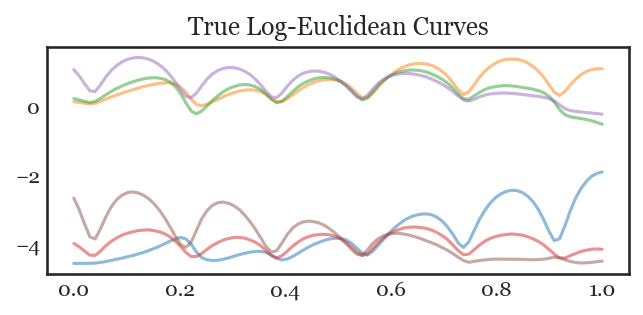

In [101]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(6):
    plt.plot(np.linspace(0, 1, 100), mean_upper[:, i], alpha=0.5, label='{}'.format(i))
plt.title('True Log-Euclidean Curves')
plt.show()

In [78]:
noisy_upper = np.zeros((200, 100, 6))
for i in range(200):
    for j in range(100):
        noisy_upper[i, j, :] = logm(noisy_covariance[i, j, :, :])[np.triu_indices(3)]

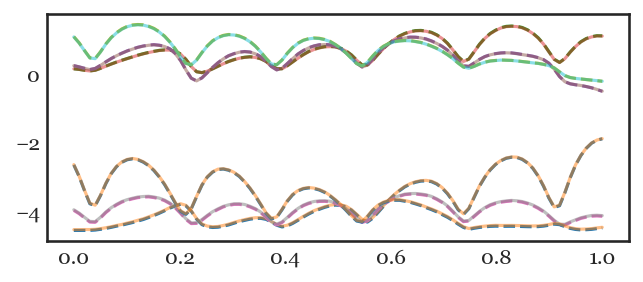

In [80]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for i in range(6):
    plt.plot(np.linspace(0, 1, 100), np.mean(noisy_upper[:, :, i], axis=0), '--', label='{}'.format(i))
    plt.plot(np.linspace(0, 1, 100), mean_upper[:, i], alpha=0.5, label='{}'.format(i))
plt.show()

In [81]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [105]:
kernel = RBF(length_scale=0.05, length_scale_bounds=(0.01, 0.5)) \
+ WhiteKernel(noise_level=0.5, noise_level_bounds=(0.01, 1.0))
model_list = []
X_train = np.linspace(0, 1, 100).reshape((100, 1))
posterior_mean = np.zeros((100, 6))
posterior_std = np.zeros((100, 6))
for i in range(6):
    y_train = noisy_upper[0, :, i]
    model = GaussianProcessRegressor(kernel=kernel).fit(X_train, y_train)
    model_list.append(model)
    current_mean, current_std = model.predict(X_train, return_std=True)
    posterior_mean[:, i] = current_mean
    posterior_std[:, i] = current_std

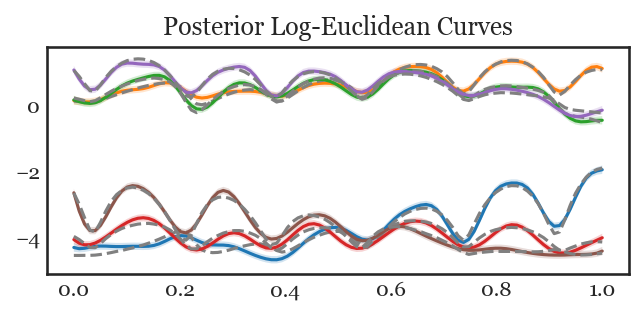

In [106]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=150)
for i in range(6):
    plt.plot(np.linspace(0, 1, 100), posterior_mean[:, i])
    ax.fill_between(np.linspace(0, 1, 100), posterior_mean[:, i] - posterior_std[:, i], posterior_mean[:, i] + posterior_std[:, i], alpha=0.2)
    plt.plot(np.linspace(0, 1, 100), mean_upper[:, i], '--', color='gray')
plt.title('Posterior Log-Euclidean Curves')
plt.show()

In [90]:
posterior_covariance = np.zeros((10, 3, 3))
for i in range(10):
    posterior_covariance[i, :, :] = expm(create_symmetric_matrix(posterior_mean[i * 10, :]))

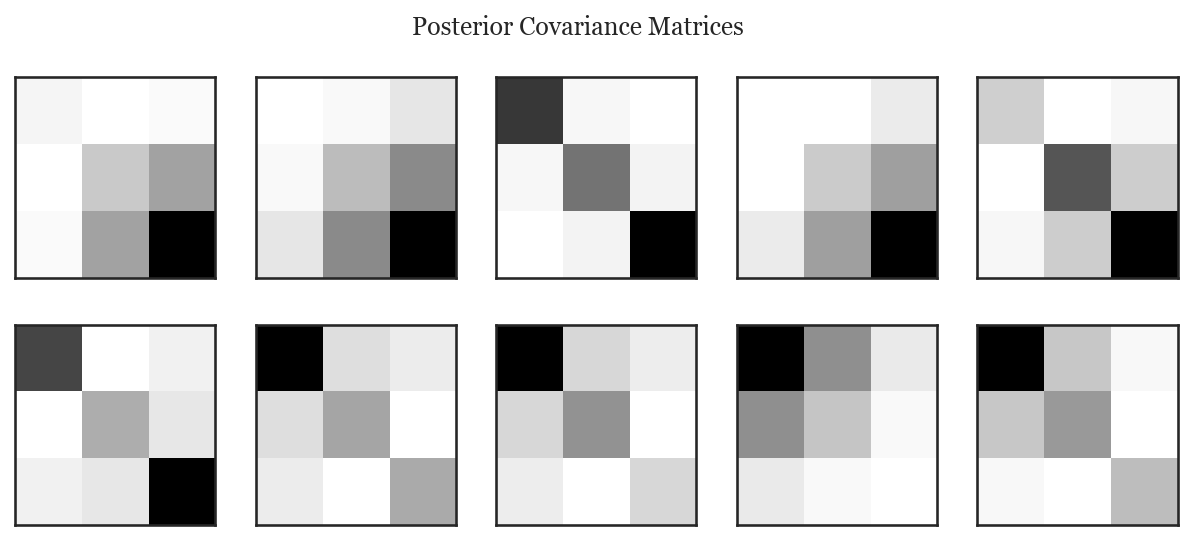

In [103]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for j in range(10):
    plt.subplot(2, 5, j + 1)
    plt.imshow(posterior_covariance[j, :, :])
    plt.xticks([])
    plt.yticks([])
#plt.colorbar()
plt.suptitle('Posterior Covariance Matrices')
plt.show()